#Using Tabula Sapiens as a reference for annotating new datasets
This notebook allows you to annotate your data with a number of annotation methods using the Tabula Sapiens dataset as the reference. 

Initial setup: 
1. Make sure GPU is enabled (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU)
2. We also highly recommend getting Colab PRO for access to a high ram session.


Integration Methods Provided:
- scVI
- bbKNN
- scanorama

Annotation Methods:
- KNN on integrated spaces
- scANVI
- onClass
- SVM
- RandomForest

To use the notebook, simply connect to your Google Drive account, set the necessary arguments, select your methods, and run all the code blocks!

**User action is only required in Step 2 and Step 3.**

Last edited: 5/13/2021



# Step 1: Setup Environment 
No user input required here.

In [1]:
%%capture
#@title Setup Colab
#@markdown Here we install the necessary packages
#@markdown This will take a few minutes (~5 min)
#import sys
#import os
#!pip install --quiet obonet
#!pip install --quiet --upgrade jsonschema
#!pip install --quiet bbknn
#!pip install --quiet git+https://github.com/wangshenguiuc/OnClass@21232f293a549a7ee0da8ebe3cbb22df3e885d4c
#!pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]
#!pip install --quiet imgkit
#!pip install --quiet gdown
#!pip install --quiet --upgrade scanorama
#!pip install scikit-learn==0.22.2
#!pip install importlib-metadata==1.7.0

# Download annoation code
#!wget -O annotation.py -q https://www.dropbox.com/s/id8sallwrunjc5c/annotation.py?dl=1

In [5]:
import sys
import os
import anndata
import numpy as np
import scanpy as sc
import scvi

# Step 2: Load your data (User Action Required)
Here we provide three options to load your data:
1. Connect to Google Drive (highly recommended)
2. Download your data from the cloud and save into this session or on Google drive.
3. Upload your data manually into this session (files are not persistent and will be deleted when session is closed)

As an example, we use a subsampled version of the [Lung Cell Atlas](https://hlca.ds.czbiohub.org/) \[1] for our query data.

\[1] Travaglini, K. et al. A molecular cell atlas of the human lung from single-cell RNA sequencing. *Nature* **587**, 619–625(2020).

In [5]:
# Get working directory
os.getcwd()

'/faststorage/project/THOR/anton/sc_athero'

In [ ]:
# OPTION 1: Connect to Google Drive
# This is the recomended method especially for large datasets
#from google.colab import drive    
#drive.mount('/content/drive')

query_adata = anndata.read('/content/drive/MyDrive/WORKING/sc_athero/sc_athero_comb.h5ad')

In [ ]:
# OPTION 2: Downloading from the cloud (Dropbox, AWS, Google Drive, etc)
# Google Colab supports wget, curl, and gdown commands
# It is recommended to download the data into Google Drive and read from there.
# This way your data will be persistent.
!wget <YOUR URL>
query_adata = anndata.read('/path/to/your/anndata')

In [6]:
# OPTION 3: Uploading data manually
# Click the folder icon on the left navigation bar, and select the upload icon
# Note: Manually uploaded data is automatically deleted when the colab session ends
# This is not recommended if your dataset is very large
query_adata = anndata.read('sc_athero_comb.h5ad')

In [9]:
# Download an example dataset:
#!wget -O LCA.h5ad https://www.dropbox.com/s/mrf8y7emfupo4he/LCA.h5ad?dl=1
query_adata = anndata.read('LCA.h5ad')

In [7]:
print(query_adata)
query_adata.obs

AnnData object with n_obs × n_vars = 71880 × 25461
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_id', 'percent_mito', 'percent_ribo', 'percent_hb', 'nCount_SCT', 'nFeature_SCT', 'dataset_author', 'singler', 'integrated_snn_res.0.5', 'seurat_clusters', 'integrated_snn_res.0.4', 'integrated_snn_res.0.3'
    var: 'name'
    obsm: 'X_pca', 'X_umap', 'X_tsne'


,orig.ident,nCount_RNA,nFeature_RNA,sample_id,percent_mito,percent_ribo,percent_hb,nCount_SCT,nFeature_SCT,dataset_author,singler,integrated_snn_res.0.5,seurat_clusters,integrated_snn_res.0.4,integrated_snn_res.0.3
index,,,,,,,,,,,,,,,
GSM4837523_AAACCCAAGATTAGAC-1,alsaigh,12045.0,2976,GSM4837523,2.523869,19.186384,0.008302,5726.0,2311,Alsaigh,Monocyte,9,6,10,6
GSM4837523_AAACCCAAGCATGTTC-1,alsaigh,5559.0,1546,GSM4837523,3.741680,34.304731,0.000000,5204.0,1546,Alsaigh,T_cells,1,1,2,1
GSM4837523_AAACCCAAGCCTGTCG-1,alsaigh,1517.0,599,GSM4837523,7.119314,26.631510,0.000000,4051.0,724,Alsaigh,T_cells,0,0,0,0
GSM4837523_AAACCCAAGGGTTTCT-1,alsaigh,9347.0,2587,GSM4837523,1.754574,12.282016,0.010699,5707.0,2408,Alsaigh,Monocyte,9,6,10,6
GSM4837523_AAACCCAAGTGCACCC-1,alsaigh,12135.0,2659,GSM4837523,1.829419,17.313556,0.148331,5626.0,2006,Alsaigh,Monocyte,8,6,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3819863_TTTGGTTCAATTGCTG-1,wirka,3254.0,1189,GSM3819863,1.290719,25.998771,0.030731,3070.0,1189,Wirka,Monocyte,2,2,1,2
GSM3819863_TTTGGTTTCTCTGTCG-1,wirka,8762.0,2527,GSM3819863,1.072814,11.298790,0.000000,3822.0,1929,Wirka,Smooth_muscle_cells,3,4,4,4
GSM3819863_TTTGTCACAAAGTGCG-1,wirka,5675.0,1929,GSM3819863,1.903084,18.290749,0.000000,3621.0,1853,Wirka,Tissue_stem_cells,5,5,5,5


In [4]:
print(query_adata.X[12])

  (0, 10)	1.0
  (0, 16)	1.0
  (0, 25)	1.0
  (0, 34)	1.0
  (0, 35)	2.0
  (0, 46)	1.0
  (0, 56)	3.0
  (0, 73)	1.0
  (0, 80)	1.0
  (0, 93)	1.0
  (0, 107)	23.0
  (0, 112)	1.0
  (0, 118)	1.0
  (0, 123)	1.0
  (0, 127)	2.0
  (0, 134)	4.0
  (0, 140)	1.0
  (0, 142)	20.0
  (0, 163)	1.0
  (0, 164)	1.0
  (0, 165)	1.0
  (0, 168)	1.0
  (0, 170)	1.0
  (0, 174)	1.0
  (0, 179)	2.0
  :	:
  (0, 21203)	1.0
  (0, 21205)	1.0
  (0, 21206)	1.0
  (0, 21213)	1.0
  (0, 21214)	1.0
  (0, 21216)	1.0
  (0, 21217)	1.0
  (0, 21221)	1.0
  (0, 21224)	1.0
  (0, 21228)	6.0
  (0, 21232)	1.0
  (0, 21242)	1.0
  (0, 21247)	1.0
  (0, 21248)	12.0
  (0, 21249)	13.0
  (0, 21250)	69.0
  (0, 21251)	20.0
  (0, 21252)	1.0
  (0, 21253)	16.0
  (0, 21254)	26.0
  (0, 21255)	11.0
  (0, 21256)	4.0
  (0, 21257)	19.0
  (0, 21258)	12.0
  (0, 21260)	27.0


## Check that query_adata.X contains raw_counts

In [8]:
#from scipy.optimize import linear_sum_assignment as linear_assignment
from annotation import _check_nonnegative_integers

assert _check_nonnegative_integers(query_adata.X) == True, 'Make sure query_adata.X contains raw_counts'

Instructions for updating:
non-resource variables are not supported in the long term


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Step 3: Setting Up Annotation Parameters (User Action Required)

Here is where you set the parameters for the automated annotation.

Arguments:
- **tissue:** Tabula Sapiens tissue to annotate your data with. Available tissues: ["Bladder", "Blood", "Bone_Marrow", "Kidney", "Large_Intestine", "Lung","Lymph_Node", "Pancreas", "Small_Intestine", "Spleen", "Thymus","Trachea", "Vasculature"]
- **save_location:** location to save results to. By default will save to a folder named `annotation_results`. It is highly recommended you provide a Google Drive folder here.
- **query_batch_key:** key in `query_adata.obs` for batch correction. Set to None for no batch correction. 
- **methods:** these are the methods to run. By default, will run all methods.
- **training_mode** can be `online` or `offline`. If `offline` will train scVI and scANVI models from scratch. If `online`, will use pretrained models.

Lesser used parameters
- **query_labels_key**: scANVI has the option to use labeled cells in the query dataset during training. To use some prelabeled cells from the query dataset, set `query_labels_key` to the corresponding key in `query_adata.obs`
- **unknown_celltype_label**: If `query_labels_key` is not None, will treat everything not labeled `unknown_celltype_label` as a labeled cell

In [9]:
""" 
tissue options: 
["Bladder", "Blood", "Bone_Marrow", "Kidney", "Large_Intestine", "Lung",
 "Lymph_Node", "Pancreas", "Small_Intestine", "Spleen", "Thymus",
 "Trachea", "Vasculature"]
"""
tissue = 'Vasculature'
save_folder = './'
query_batch_key = 'sample_id'
methods = ['bbknn','scvi', 'scanvi', 'svm', 'rf', 'onclass', 'scanorama']
training_mode='online'

# Lesser used parameters
query_labels_key=None
unknown_celltype_label='unknown'

# Step 4: Downloading Reference Data and Pretrained Models
No more user input required! Just run all the following code blocks.

In [7]:
# Here we download the necessary data:
if tissue == 'Bladder':
  refdata_url = 'https://ndownloader.figshare.com/files/27388874'
  pretrained_url='https://www.dropbox.com/s/rb89y577l6vs2mm/Bladder.tar.gz?dl=1'
elif tissue == 'Blood':
  refdata_url = 'https://ndownloader.figshare.com/files/27388853'
  pretrained_url = 'https://www.dropbox.com/s/kyh9nv202n0db65/Blood.tar.gz?dl=1'
elif tissue == 'Bone_Marrow':
  refdata_url = 'https://ndownloader.figshare.com/files/27388841'
  pretrained_url = 'https://www.dropbox.com/s/a3r4ddg7o7kua7z/Bone_Marrow.tar.gz?dl=1'
elif tissue == 'Kidney':
  refdata_url = 'https://ndownloader.figshare.com/files/27388838'
  pretrained_url = 'https://www.dropbox.com/s/k41r1a346z0tuip/Kidney.tar.gz?dl=1'
elif tissue == 'Large_Intestine':
  refdata_url = 'https://ndownloader.figshare.com/files/27388835'
  pretrained_url = 'https://www.dropbox.com/s/jwvpk727hd54byd/Large_Intestine.tar.gz?dl=1'
elif tissue == 'Lung':
  refdata_url = 'https://ndownloader.figshare.com/files/27388832'
  pretrained_url = 'https://www.dropbox.com/s/e4al4ia9hm9qtcg/Lung.tar.gz?dl=1'
elif tissue == 'Lymph_Node':
  refdata_url = 'https://ndownloader.figshare.com/files/27388715'
  pretrained_url = 'https://www.dropbox.com/s/mbejy9tcbx9e1yv/Lymph_Node.tar.gz?dl=1'
elif tissue == 'Pancreas':
  refdata_url = 'https://ndownloader.figshare.com/files/27388613'
  pretrained_url = 'https://www.dropbox.com/s/r3klvr22m6kq143/Pancreas.tar.gz?dl=1'
elif tissue == 'Small_Intestine':
  refdata_url = 'https://ndownloader.figshare.com/files/27388559'
  pretrained_url = 'https://www.dropbox.com/s/7eiv2mke70jinzc/Small_Intestine.tar.gz?dl=1'
elif tissue == 'Spleen':
  refdata_url = 'https://ndownloader.figshare.com/files/27388544'
  pretrained_url = 'https://www.dropbox.com/s/6j3iwahsjnb8rb3/Spleen.tar.gz?dl=1'
elif tissue == 'Thymus':
  refdata_url = 'https://ndownloader.figshare.com/files/27388505'
  pretrained_url='https://www.dropbox.com/s/9k0mneu2wvpiudz/Thymus.tar.gz?dl=1'
elif tissue == 'Trachea':
  refdata_url = 'https://ndownloader.figshare.com/files/27388460'
  pretrained_url = 'https://www.dropbox.com/s/57tthfgkl8jtxk6/Trachea.tar.gz?dl=1'
elif tissue == 'Vasculature':
  refdata_url = 'https://ndownloader.figshare.com/files/27388451'
  pretrained_url='https://www.dropbox.com/s/1wt3r871kxjas5o/Vasculature.tar.gz?dl=1'

# Download reference dataset
output_fn = 'TS_{}.h5ad'.format(tissue)
!wget -O $output_fn $refdata_url

# Download pretrained scVI and scANVI models.
output_fn = '{}.tar.gz'.format(tissue)
!wget -O $output_fn $pretrained_url
!tar -xvzf $output_fn

# Download onclass files
!wget -O cl.obo -q https://www.dropbox.com/s/hodp0etapzrd8ak/cl.obo?dl=1 
!wget -O cl.ontology -q https://www.dropbox.com/s/nes0zprzfbwbgj5/cl.ontology?dl=1
!wget -O cl.ontology.nlp.emb https://www.dropbox.com/s/y9x9yt2pi7s0d1n/cl.ontology.nlp.emb?dl=1

--2022-01-07 23:20:03--  https://www.dropbox.com/s/1wt3r871kxjas5o/Vasculature.tar.gz?dl=1
Resolving proxyserv (proxyserv)... 10.220.5.30
Connecting to proxyserv (proxyserv)|10.220.5.30|:3128... connected.
Proxy request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/1wt3r871kxjas5o/Vasculature.tar.gz [following]
--2022-01-07 23:20:03--  https://www.dropbox.com/s/dl/1wt3r871kxjas5o/Vasculature.tar.gz
Reusing existing connection to www.dropbox.com:443.
Proxy request sent, awaiting response... No data received.
Retrying.

--2022-01-07 23:20:05--  (try: 2)  https://www.dropbox.com/s/dl/1wt3r871kxjas5o/Vasculature.tar.gz
Connecting to proxyserv (proxyserv)|10.220.5.30|:3128... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://uccd5d292f49919e3c48672449dc.dl.dropboxusercontent.com/cd/0/get/BdVw2FkkeXpCvAow6sRXzJN_m16oQ_KzLEghV4Ipae07rwxOWpUL-oO6BHTHzzm1UhSgSNQlc-CyvLvrgweem8qp0HDXADTbqUGBj7T3W-cjmqiwF-ZCCfFdrx_z1-5OxkOyolvWyi_9VmTLhClBMmJF/file

## Setup the reference dataset

In [10]:
# read in the reference dataset
ref_adata_path = 'TS_{}.h5ad'.format(tissue)
ref_adata = anndata.read(ref_adata_path)

In [11]:
# Here we filter out the cells that were not manually annotated
# This way we only train on expert annotated data
ref_adata = ref_adata[ref_adata.obs["Manually Annotated"] == "True"].copy()

# We wish to correct for batch effects from donor and method
# So we make a new batch key that will be passed to the methods
ref_adata.obs['donor_method'] = ref_adata.obs['Donor'].astype(str) + ref_adata.obs['Method'].astype(str)

# The annotation pipeline expects raw counts in the the X field
ref_adata.X = ref_adata.layers['raw_counts']

# Following parameters are specific to Tabula Sapiens dataset
ref_labels_key='Annotation'
ref_batch_key = 'donor_method'

## Check if we can use pretrained models


In [12]:
import os
from annotation import get_pretrained_model_genes, check_genes_is_subset
pretrained_scanvi_path = os.path.join(tissue, tissue + "_scanvi_model")
pretrained_scvi_path = os.path.join(tissue, tissue + "_scvi_model")

training_mode='online'
is_subset = False
if training_mode == 'online':
    pretrained_genes = get_pretrained_model_genes(pretrained_scvi_path)
    query_genes = query_adata.var_names.to_numpy().astype("str")
    is_subset = check_genes_is_subset(pretrained_genes, query_genes)

if is_subset and training_mode=='online':
    ref_adata = ref_adata[:, pretrained_genes]
else:
    training_mode = 'offline'


Not all reference genes are in query dataset. Retraining models.


In [13]:
# here we setup the query dataset with the reference dataset
from annotation import process_query

adata = process_query(query_adata,
                      ref_adata,
                      tissue=tissue,
                      save_folder=save_folder,
                      query_batch_key=query_batch_key,
                      query_labels_key=query_labels_key,
                      unknown_celltype_label=unknown_celltype_label,
                      pretrained_scvi_path=pretrained_scvi_path,
                      ref_labels_key=ref_labels_key, 
                      ref_batch_key=ref_batch_key,
                      training_mode=training_mode,
                      ref_adata_path=ref_adata_path)

Sampling 100 per label


/faststorage/project/THOR/anton/sc_athero/annotation.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_adata.obs["_ref_subsample"][ref_subsample_idx] = True
/home/amarkov/miniconda3/envs/ts_anno/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


INFO     Using batches from adata.obs["_batch_annotation"]                                   
INFO     Using labels from adata.obs["_labels_annotation"]                                   
INFO     Using data from adata.layers["scvi_counts"]                                         
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 80369 cells, 4000 genes, 19       
         batches, 13 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


... storing 'orig.ident' as categorical
... storing 'sample_id' as categorical
... storing 'dataset_author' as categorical
... storing 'singler' as categorical
... storing 'integrated_snn_res.0.5' as categorical
... storing 'seurat_clusters' as categorical
... storing 'integrated_snn_res.0.4' as categorical
... storing 'integrated_snn_res.0.3' as categorical
... storing '_batch_annotation' as categorical
... storing '_dataset' as categorical
... storing 'final_annotation_cell_ontology_id' as categorical
... storing '_labels_annotation' as categorical
... storing 'Annotation' as categorical
... storing 'Manually Annotated' as categorical
... storing 'Donor' as categorical
... storing 'Method' as categorical
... storing 'Organ' as categorical
... storing 'Compartment' as categorical
... storing 'Anatomical Information' as categorical
... storing 'donor_method' as categorical
... storing '_batch_annotation' as categorical
... storing '_dataset' as categorical
... storing 'final_annotation

In [14]:
print(adata)
adata.obs['_batch_annotation']

AnnData object with n_obs × n_vars = 80369 × 4000
    obs: '_labels_annotation', '_batch_annotation', '_dataset', '_ref_subsample', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_training_mode', 'log1p', 'hvg', 'pca', '_scvi'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'scvi_counts'


TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_F7_S127       TSP2smartseq2
TTGGGCGAGTCGAATA_TSP2_Vasculature_Aorta_10X_1_1                            TSP210X
CTATCTACACCATATG_TSP2_Vasculature_Aorta_10X_1_1                            TSP210X
CTAAGTGAGTGGATAT_TSP2_Vasculature_Aorta_10X_1_1                            TSP210X
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_J8_S224       TSP2smartseq2
                                                                        ...       
GSM3819863_TTTGGTTCAATTGCTG-1                                     GSM3819863_query
GSM3819863_TTTGGTTTCTCTGTCG-1                                     GSM3819863_query
GSM3819863_TTTGTCACAAAGTGCG-1                                     GSM3819863_query
GSM3819863_TTTGTCACAGGACCCT-1                                     GSM3819863_query
GSM3819863_TTTGTCAGTCACCTAA-1                                     GSM3819863_query
Name: _batch_annotation, Length: 80369, dtype: object

# Step 5: Run Automated Cell Annotation Methods
No user action required. Takes about ~1 hour for a dataset for 100k cells. 

Your results will be saved to the folder you provided as **save_folder**.

There will be the following files:
- `annotated_query.h5ad` containing annotated query cells. The consensus annotations will be in `consensus_prediction`. There will also be a `consensus_percentage` field which is the percentage of methods that had the same prediction. 
- `annotated_query_plus_ref.h5ad` containing your query and the reference cells with predicted annotations. 
- `confusion_matrices.pdf` which contains the confusion matrices between the consensus_predictions and each individual method.
- `csv` files containing the metrics for each confusion matrix. 


In [18]:
#methods = ['bbknn','scvi', 'scanvi', 'svm', 'rf', 'onclass', 'scanorama']
methods = ['bbknn','scvi', 'scanvi', 'svm', 'rf', 'scanorama']

adata.uns['_training_mode'] = 'online'
print(adata.uns['_training_mode'])

online


In [ ]:
import annotation
from annotation import annotate_data
annotate_data(adata,
              methods, 
              save_folder,
              pretrained_scvi_path=pretrained_scvi_path,
              pretrained_scanvi_path=pretrained_scanvi_path)

Integrating data with bbknn.


# Step 6 Generate Statistics and Figures
No user action required.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

results_file = os.path.join(save_folder,'annotated_query_plus_ref.h5ad')
results = anndata.read(results_file)

ERROR! Session/line number was not unique in database. History logging moved to new session 15


In [ ]:
from annotation import make_agreement_plots
all_prediction_keys = [
        "knn_on_bbknn_pred",
        "knn_on_scvi_online_pred",
        "knn_on_scvi_offline_pred",
        "scanvi_online_pred",
        "scanvi_offline_pred",
        "svm_pred",
        "rf_pred",
        "onclass_pred",
        "knn_on_scanorama_pred",
    ]

obs_keys = adata.obs.keys()
pred_keys = [key for key in obs_keys if key in all_prediction_keys]
make_agreement_plots(results, methods=pred_keys, save_folder=save_folder)

is_query = results.obs._dataset == "query"
methods = [x for x in results.obs.columns if x.endswith("_pred")]
labels = results.obs.consensus_prediction.astype(str)
labels[~is_query] = results[~is_query].obs._labels_annotation.astype(str)
celltypes = np.unique(labels)
latent_methods = results.obsm.keys()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Making confusion matrix for knn_on_bbknn_pred
Traceback (most recent call last):
  File "D:\Apps\Miniconda3\envs\sc\lib\site-packages\pandas\core\indexes\base.py", line 2898, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1675, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1683, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'consensus_prediction'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "D:\Apps\Miniconda3\envs\sc\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\alone\AppData\Local\Temp/ipykernel_3156/3563741615.p

### Distribution of consensus percentage
The more the algorithms agree with each other, the better the annotation has worked

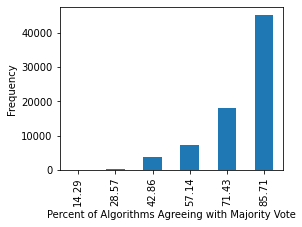

In [ ]:
agreement_counts = pd.DataFrame(
    np.unique(results[is_query].obs["consensus_percentage"], return_counts=True)
).T

agreement_counts.columns = ["Percent Agreement", "Count"]
agreement_counts.plot.bar(
    x="Percent Agreement", y="Count", legend=False, figsize=(4, 3)
)
plt.ylabel("Frequency")
plt.xlabel("Percent of Algorithms Agreeing with Majority Vote")
figpath = os.path.join(save_folder, "Concensus_Percentage_barplot.pdf")
plt.savefig(figpath, bbox_inches="tight")

### Per cell type agreement
Some cell types can be better predicted than others, and we can highlight the celltypes that are poorly predicted by looking at the per celltype agreement. The cell types are separated by the concensus predictions.

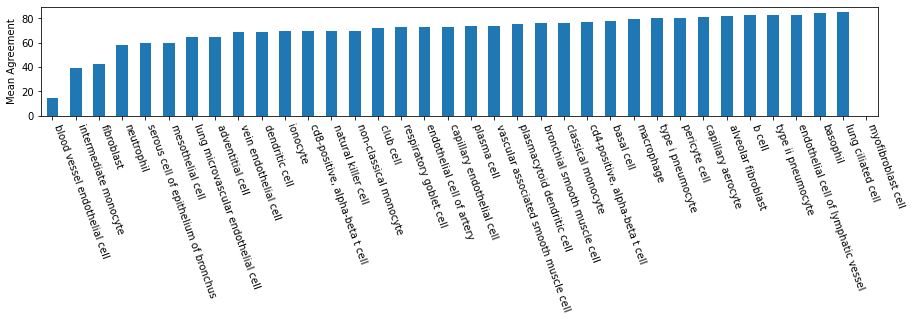

In [ ]:
mean_agreement = [
    np.mean(results[is_query & (labels == x)].obs["consensus_percentage"].astype(float))
    for x in celltypes
]
mean_agreement = pd.DataFrame([mean_agreement], index=["agreement"]).T
mean_agreement.index = celltypes

mean_agreement = mean_agreement.sort_values("agreement", ascending=True)
mean_agreement.plot.bar(y="agreement", figsize=(15, 2), legend=False)
plt.ylabel("Mean Agreement")
plt.xticks(rotation=290, ha="left")
figpath = os.path.join(save_folder, "percelltype_agreement_barplot.pdf")
plt.savefig(figpath, bbox_inches="tight")

### Cell type proportion plot

In [ ]:
prop = pd.DataFrame(index=celltypes, columns=["ref", "query"])
for x in celltypes:
    prop.loc[x, "query"] = np.sum(labels[is_query] == x)
    prop.loc[x, "ref"] = np.sum(labels[~is_query] == x)


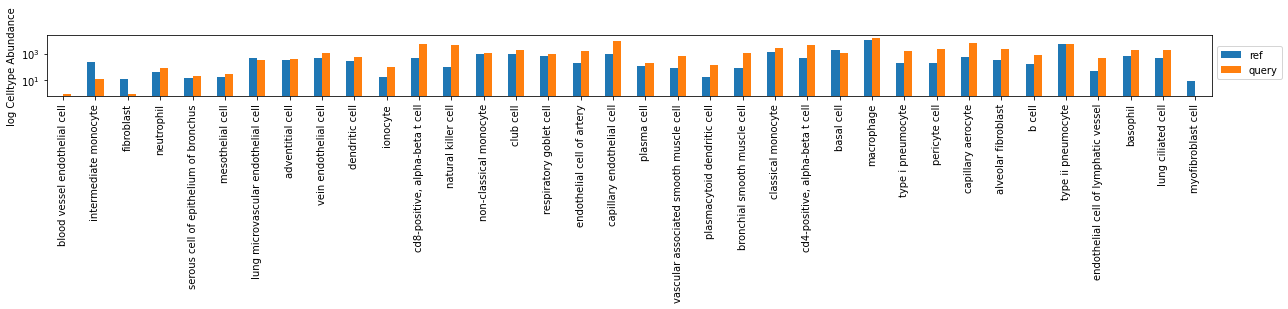

In [ ]:
prop.loc[mean_agreement.index].plot(kind='bar', figsize=(len(celltypes)*0.5,4),logy=True)
plt.legend(bbox_to_anchor=(1, 0.9))
plt.ylabel('log Celltype Abundance')
plt.tight_layout()
figpath = os.path.join(save_folder, 'celltype_prop_barplot.pdf')
plt.savefig(figpath, bbox_inches="tight")
plt.show()
plt.close()
